In [1]:
import pymc as pm
import numpy as np
from scipy import stats
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv("/home/osvaldo/proyectos/00_BM/BMCP_org/BookCode_Edition1/data/air_pollution_bsas.csv")
bsas_co = data["co"].dropna().values

bsas_co

array([0.539     , 0.669     , 0.3225    , ..., 0.63458333, 0.7125    ,
       0.4975    ])

In [2]:
class g_and_k_quantile:    
    def __init__(self):
        self.quantile_normal = stats.norm(0, 1).ppf
        self.pdf_normal = stats.norm(0, 1).pdf

    def ppf(self, x, a, b, g, k):
        z = self.quantile_normal(x)
        return a + b * (1 + 0.8 * np.tanh(g*z/2)) * ((1 + z**2)**k) * z

    
    def rvs(self, rng, a, b, g, k, size):
        x = rng.uniform(0, 1, size)
        return self.ppf(x, a, b, g, k)

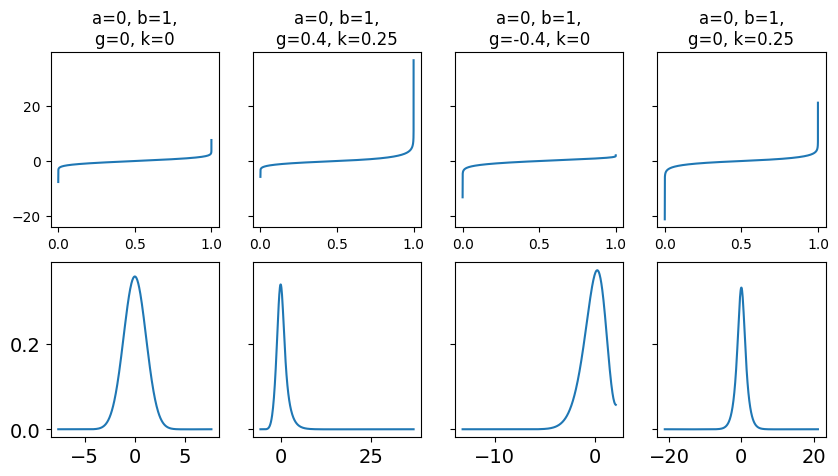

In [3]:
gk = g_and_k_quantile()
u = np.linspace(1E-14, 1-1E-14, 10000)

params = ((0, 1, 0, 0), 
 (0, 1, .4, 0.25),
 (0, 1,-.4, 0),
 (0, 1, 0, 0.25))

_, ax = plt.subplots(2, 4, sharey="row", figsize=(10, 5))
for i, p in enumerate(params):
    a, b, g, k = p
    ppf = gk.ppf(u, a, b, g, k)
    ax[0, i].plot(u, ppf)
    ax[0, i].set_title(f"a={a}, b={b},\ng={g}, k={k}")
    #ax[1, i].plot(x, gk.pdf(x, a, b, g, k))
    az.plot_kde(ppf, ax=ax[1, i], bw=0.5)

In [9]:
sc = pd.read_csv("sc.csv", header=None)[0].values
sc

array([694, 664, 603, ...,   0,   0,   0])

In [10]:
gk = g_and_k_quantile()
def gk_simulator(rng, a, b, g, k, size=len(sc)):
    return gk.rvs(rng, a, b, g, k, size)

In [11]:
def octo_summary(x):
    e1, e2, e3, e4, e5, e6, e7 = np.quantile(
        x, [.125, .25, .375, .5, .625, .75, .875])
    sa = e4
    sb = e6 - e2
    sg = (e6 + e2 - 2*e4)/sb
    sk = (e7 - e5 + e3 - e1)/sb
    return np.array([sa, sb, sg, sk])

In [34]:
with pm.Model() as gkm:
    a = pm.HalfNormal("a", sigma=5)
    b = pm.HalfNormal("b", sigma=5)
    g = pm.HalfNormal("g", sigma=5)
    k = pm.HalfNormal("k", sigma=0.1)
    
    s = pm.Simulator("s", gk_simulator, params=(a, b, g, k),        
                     sum_stat=octo_summary,
                     epsilon=2,
                     observed=sc)
    
    trace_gk = pm.sample_smc()

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


array([[<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'g'}>,
        <AxesSubplot:title={'center':'g'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'k'}>,
        <AxesSubplot:title={'center':'k'}, xlabel='Rank (all chains)'>]],
      dtype=object)

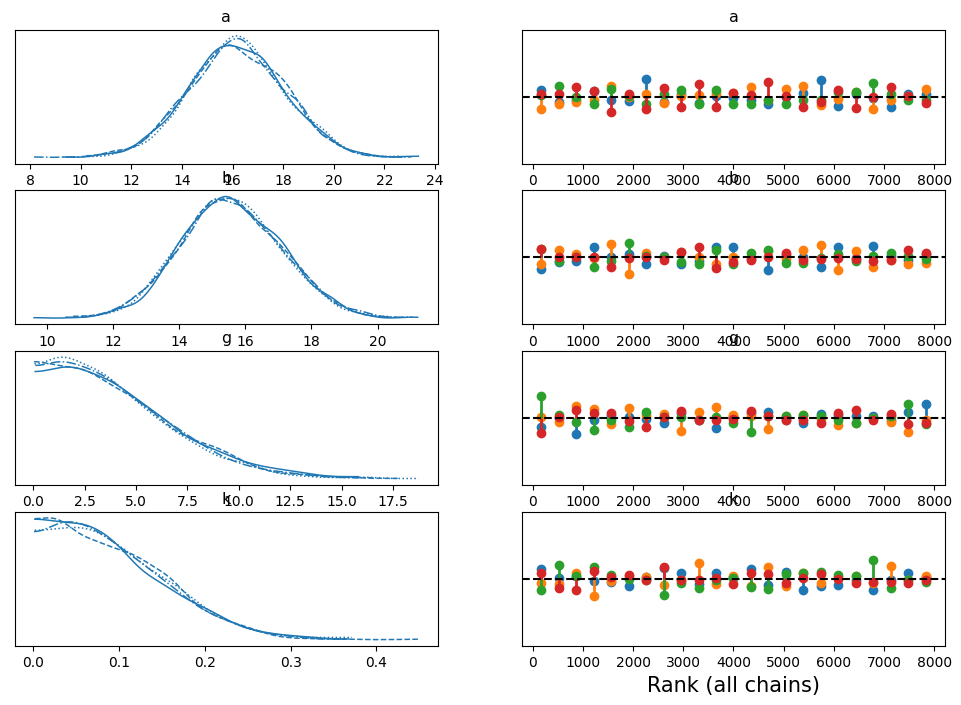

In [35]:
az.plot_trace(trace_gk, kind="rank_vlines")

In [36]:
az.summary(trace_gk)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,16.169,1.883,12.755,19.772,0.021,0.015,7736.0,7690.0,1.0
b,15.575,1.508,12.829,18.456,0.017,0.012,7674.0,6408.0,1.0
g,4.102,2.978,0.077,9.489,0.034,0.024,7407.0,7406.0,1.0
k,0.094,0.066,0.001,0.210,0.001,0.001,7071.0,6782.0,1.0


<AxesSubplot:title={'center':'a=16, b=9,\ng=4, k=0'}>

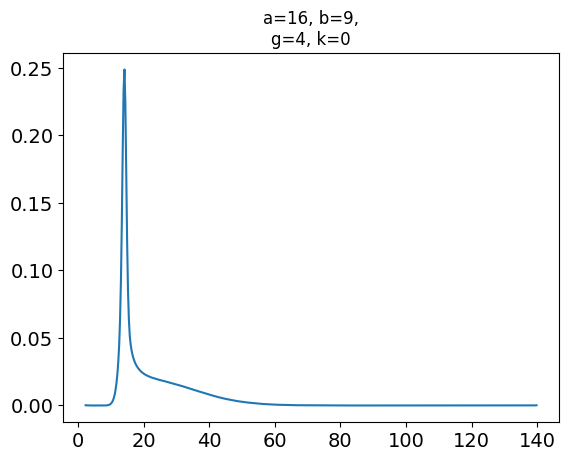

In [32]:
gk = g_and_k_quantile()
u = np.linspace(1E-14, 1-1E-14, 10000)

a, b, g, k = 16, 9, 4, 0
ppf = gk.ppf(u, a, b, g, k)
_, ax = plt.subplots(1, 1)
#ax.plot(u, ppf)
ax.set_title(f"a={a}, b={b},\ng={g}, k={k}")
az.plot_kde(ppf, ax=ax, bw=0.5)

In [ ]:
data = np.random.normal(loc=0, scale=1, size=1000)

def normal_sim(rng, a, b, size=1000):
    return rng.normal(a, b, size=size)


with pm.Model() as example:
    a = pm.Normal("a", mu=0, sigma=5)
    b = pm.HalfNormal("b", sigma=1)
    s = pm.Simulator("s", normal_sim, params=(a, b), sum_stat="sort", epsilon=1, observed=data)

    idata = pm.sample_smc()
    idata.extend(pm.sample_posterior_predictive(idata))

array([694, 664, 603, ...,   0,   0,   0])